# ML-based Appraoch
- Feature Eng 
    - Event Base Feature Engineering
    - Capture only Cross-sell/Upsell Policy Purchase Events
        - Single Purchase events are discarded in this modelling, although it is possible to make use of them to extracts demography favourable for certain policies at times.

    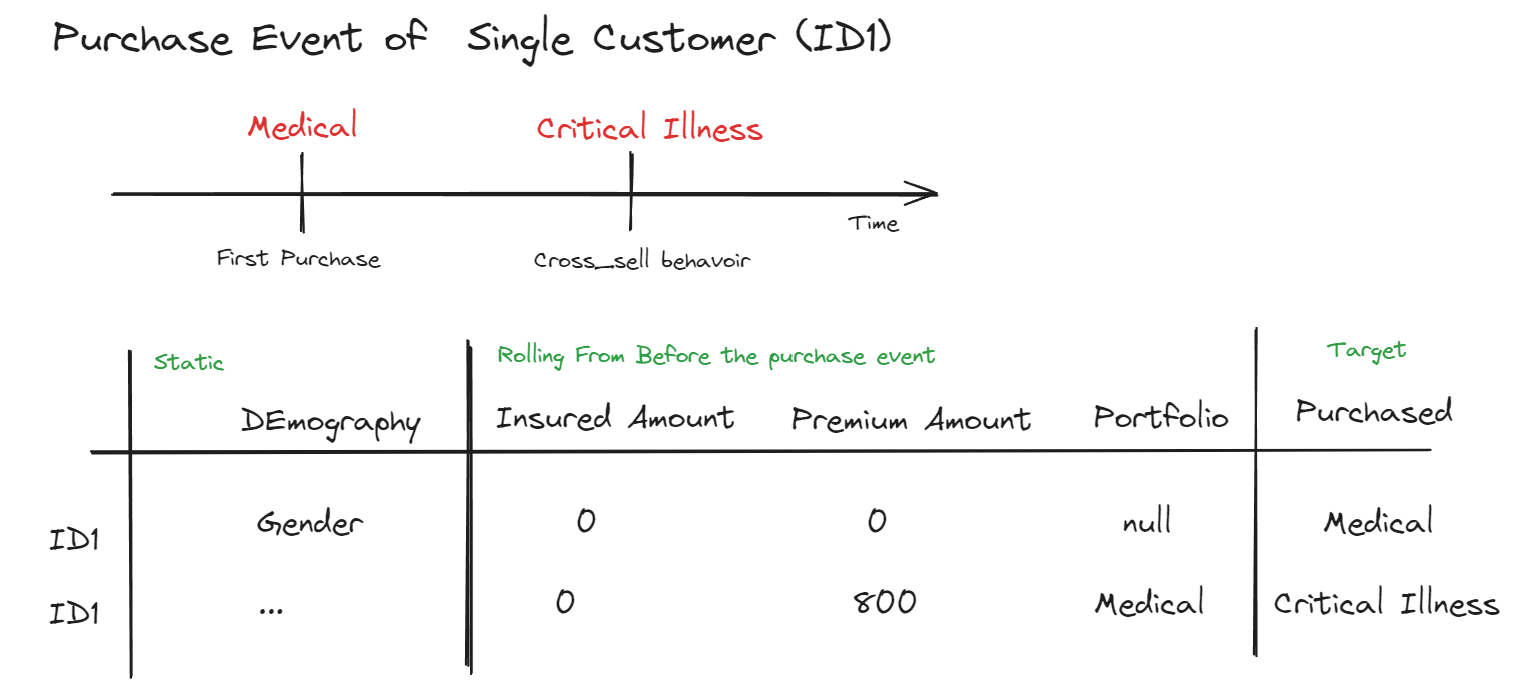


- ML Training
    - Premodel processing
        - Casting/Train Val Seperation
    - LightGBM Model


    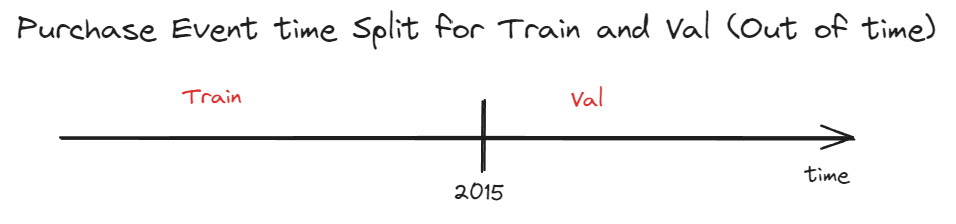

# Library

In [49]:
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

import math

# Input

In [50]:
df = pl.read_parquet("data/L1/generated_data.parquet")
df = df.drop(["under_insured", "high_income", "dependents_needs", "recent_purchase"])

# Polar Eng

There are multiple ways we can try to phase this cross-sell/up-sell features. One of it is feature based, whereby we would consider every purchase event
- This is done to bypass the typical situation whereby there isnt' surfficient data for Cross-selling
    - Hence, we would take accounts of both single and multiple purchase from customers.
    - We can modulate it through weights of the feature/sample.
- Another method would be just to time split the purchase behavior of customers

## Policies Events

In [51]:
policy_issue_event = (
    df.rename({"Policy_Issue_Date": "Event_Date"})
    .drop("Policy_Terminate_Date")
    .with_columns(pl.lit(1).alias("Policy_Count"))[
        [
            "CustomerID",
            "Event_Date",
            "Policy",
            "Policy_Count",
            "Premium_Amount",
            "Insured_Amount",
        ]
    ]
)


policy_terminate_event = (
    df.filter(pl.col("Policy_Terminate_Date").is_not_null())
    .rename({"Policy_Terminate_Date": "Event_Date"})
    .with_columns(
        pl.col("Premium_Amount") * -1,
        pl.col("Insured_Amount") * -1,
    )
    .with_columns(pl.lit(-1).alias("Policy_Count"))[
        [
            "CustomerID",
            "Event_Date",
            "Policy",
            "Policy_Count",
            "Premium_Amount",
            "Insured_Amount",
        ]
    ]
)

policy_event = pl.concat([policy_issue_event, policy_terminate_event])

## Policies Rolling

### Train

In [52]:
policy_rolling = (
    policy_event.lazy()
    .sort(["CustomerID", "Event_Date"])
    .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="left")
    .agg(
        pl.col("*").sum(),
    )
    .drop("Policy")
).collect()


# Filter for only purchase events
policy_rolling_train = (
    policy_rolling.join(
        policy_event[["Policy", "Policy_Count", "CustomerID", "Event_Date"]],
        on=["CustomerID", "Event_Date"],
    )
    .rename({"Policy_Count_right": "Purchase_Terminate", "Policy": "Purchase_Policy"})
    .filter(pl.col("Purchase_Terminate") == 1)
)

/tmp/ipykernel_677910/298486667.py:4: DeprecationWarning: The argument `by` for `LazyFrame.rolling` is deprecated. It has been renamed to `group_by`.
  .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="left")


### Score

In [53]:
policy_rolling_both = (
    policy_event.lazy()
    .sort(["CustomerID", "Event_Date"])
    .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="both")
    .agg(
        pl.col("*").sum(),
    )
    .drop("Policy")
).collect()

# extract only lastest status, select only inforce customers
policy_rolling_score = (
    policy_rolling.group_by("CustomerID").last().filter(pl.col("Policy_Count") > 0)
)

/tmp/ipykernel_677910/3808126764.py:4: DeprecationWarning: The argument `by` for `LazyFrame.rolling` is deprecated. It has been renamed to `group_by`.
  .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="both")


## Policy Portfolio

### Train

In [54]:
policy_issue_event_count = (
    df.pivot(
        index=["CustomerID", "Policy_Issue_Date"],
        columns="Policy",
        values="CustomerID",
        aggregate_function="len",
    )
    .fill_null(0)
    .rename({"Policy_Issue_Date": "Event_Date"})[
        [
            "CustomerID",
            "Event_Date",
            "Medical",
            "Critical Illness",
            "Endowment",
            "Investment",
            "Whole Life",
            "Term Life",
        ]
    ]
)
policy_terminate_event_count = (
    df.filter(pl.col("Policy_Terminate_Date").is_not_null())
    .pivot(
        index=["CustomerID", "Policy_Terminate_Date"],
        columns="Policy",
        values="CustomerID",
        aggregate_function="len",
    )
    .fill_null(0)
    .rename({"Policy_Terminate_Date": "Event_Date"})[
        [
            "CustomerID",
            "Event_Date",
            "Medical",
            "Critical Illness",
            "Endowment",
            "Investment",
            "Whole Life",
            "Term Life",
        ]
    ]
)

policy_event_counts_train = (
    pl.concat([policy_issue_event_count, policy_terminate_event_count])
    .sort("CustomerID", "Event_Date")
    # .group_by(["Customer", "Event_Date"])
    .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="left")
    .agg(
        pl.col("*").sum(),
    )
)

/tmp/ipykernel_677910/4014605910.py:2: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  df.pivot(
/tmp/ipykernel_677910/4014605910.py:24: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(
/tmp/ipykernel_677910/4014605910.py:49: DeprecationWarning: The argument `by` for `DataFrame.rolling` is deprecated. It has been renamed to `group_by`.
  .rolling(index_column="Event_Date", period="99y", by="CustomerID", closed="left")


### Score

In [55]:
policy_event_counts_score = policy_event_counts_train.group_by("CustomerID").last()

## Static Features

In [56]:
static_features = df[
    [
        "CustomerID",
        "Gender",
        "Age",
        # "Cust_Birthday",
        "Income",
        "Marital_Status",
        "Dependents",
        "Claims",
        "Smoker",
        "Payment_Timeliness",
        "Payment_Frequency",
        "Payment_Method",
        "Recent_Payment_Months",
    ]
]

static_features = static_features.group_by("CustomerID").last()

## Combined

In [57]:
policy_train_df = policy_event_counts_train.join(
    policy_rolling_train, on=["CustomerID", "Event_Date"]
)
policy_score_df = policy_event_counts_score.join(
    policy_rolling_score, on=["CustomerID"]
)

policy_train_df = policy_train_df.join(static_features, on="CustomerID")
policy_score_df = policy_score_df.join(static_features, on="CustomerID")

# Intermediate Output

In [58]:
policy_train_df.write_parquet("data/L2/feature_eng_train.parquet")
policy_score_df.write_parquet("data/L2/feature_eng_score.parquet")

# Premodel processing

In [59]:
policy_train_df = pl.read_parquet("data/L2/feature_eng_train.parquet")
policy_score_df = pl.read_parquet("data/L2/feature_eng_score.parquet")

In [60]:
train = policy_train_df.filter(pl.col("Policy_Count") > 0)
score = policy_score_df

train = train.to_pandas()
score = score.to_pandas()

### Casting

In [61]:
col_to_cast = [
    "Medical",
    "Critical Illness",
    "Endowment",
    "Investment",
    "Whole Life",
    "Term Life",
]

for i in col_to_cast:
    train[i] = train[i].astype(int)
    score[i] = score[i].astype(int)

col_to_cast = [
    "Payment_Timeliness",
    "Payment_Frequency",
    "Payment_Method",
    "Marital_Status",
    "Gender",
    "Claims",
]

for i in col_to_cast:
    train[i] = train[i].astype("category")
    score[i] = score[i].astype("category")

train["Event_Date"] = pd.to_datetime(train["Event_Date"])
score["Event_Date"] = pd.to_datetime(score["Event_Date"])

### Train/ Val Seperation

In [62]:
train_df = train.loc[train["Event_Date"] < datetime.datetime(2015, 1, 1)]
val_df = train.loc[train["Event_Date"] >= datetime.datetime(2015, 1, 1)]

In [63]:
X_train = train_df.drop(["CustomerID", "Event_Date"], axis=1)
X_val = val_df.drop(["CustomerID", "Event_Date"], axis=1)
X_score = score.drop(["CustomerID", "Event_Date"], axis=1)

In [64]:
policy_cat_map = {
    "Medical": 0,
    "Critical Illness": 1,
    "Endowment": 2,
    "Investment": 3,
    "Whole Life": 4,
    "Term Life": 5,
}

X_train["Purchase_Policy"] = X_train["Purchase_Policy"].replace(policy_cat_map)
X_val["Purchase_Policy"] = X_val["Purchase_Policy"].replace(policy_cat_map)

/tmp/ipykernel_677910/901931169.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train["Purchase_Policy"] = X_train["Purchase_Policy"].replace(policy_cat_map)
/tmp/ipykernel_677910/901931169.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val["Purchase_Policy"] = X_val["Purchase_Policy"].replace(policy_cat_map)


In [65]:
y_train = X_train.pop("Purchase_Policy")
y_val = X_val.pop("Purchase_Policy")

In [66]:
X_train.to_parquet("data/L2/X_train.parquet")
pd.DataFrame(y_train).to_parquet("data/L2/y_train.parquet")
X_val.to_parquet("data/L2/X_val.parquet")
pd.DataFrame(y_val).to_parquet("data/L2/y_val.parquet")
X_score.to_parquet("data/L2/X_score.parquet")

In [67]:
import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary
import joblib

wandb.login()

import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# LGBM Model

In [68]:
# train
# add lightgbm callback
parmas = {"objective": "multiclass", "num_class": 6, "metric": "multi_logloss"}
        #   "class_weight": {'0':2000, '1':2000, '2':1, '3':1, '4':1, '4':1}

wandb_run = wandb.init(project="ai-coding-project", config=parmas)
gbm = lgb.train(
    parmas,
    lgb_train,
    num_boost_round=30,
    valid_sets=lgb_eval,
    valid_names=("validation"),
    callbacks=[wandb_callback()],
)

# wandb log model metrics (basic)
log_summary(gbm, save_model_checkpoint=True)

# save model
joblib.dump(gbm, "model/lgb_multiclass.pkl")

iteration,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
validation_multi_logloss,▅▃▃▂▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇██
best_iteration,0
iteration,29


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 486, number of used features: 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.365927
[LightGBM] [Info] Start training from score -1.182262
[LightGBM] [Info] Start training from score -1.424035
[LightGBM] [Info] Start training from score -2.967333
[LightGBM] [Info] Start training from score -3.478158
[LightGBM] [Info] Start training from score -2.160857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

['model/lgb_multiclass.pkl']